In [1]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error, l2_relative_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

import sys
sys.path.append('../..')
from utils.custom_models import AdaptativeDataWeightModel

2025-12-12 19:30:20.756154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:


def sir_system(t, compartments, gamma):
    S, I, R = compartments
    return [
        -beta_t(t) * S * I,
        beta_t(t) * S * I - gamma * I,
        gamma * I
    ]

In [3]:
t0, tf = 0, 50

beta_t = lambda t: t**2 / 10000 + 0.25

gamma = 0.1
S0, I0, R0 = 0.99, 0.01, 0.0

In [4]:
sir_sol = solve_ivp(
    sir_system,
    [t0, tf],
    [S0, I0, R0],
    args=[gamma],
    dense_output=True
)

nop_data = 100
train_t = np.linspace(t0, tf, nop_data)
sir_data = sir_sol.sol(train_t).T

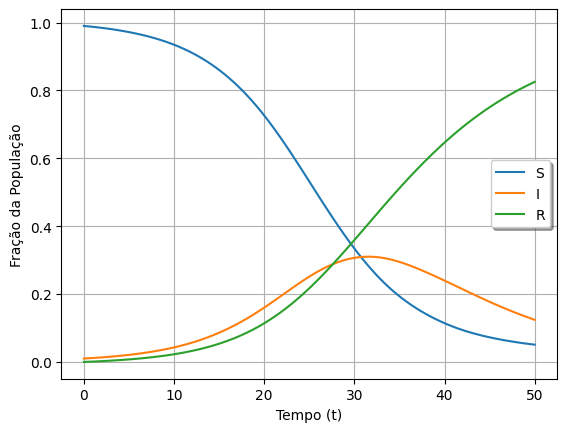

In [5]:
plt.plot(train_t, sir_data)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-predicted-compartments-mono-beta.png")
plt.show()

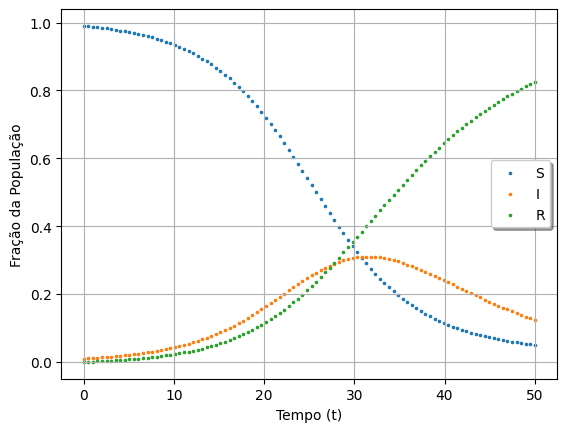

In [6]:
plt.scatter(train_t, sir_data[:, 0], s=2.5)
plt.scatter(train_t, sir_data[:, 1], s=2.5)
plt.scatter(train_t, sir_data[:, 2], s=2.5)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-data-mono-beta.png")
plt.show()

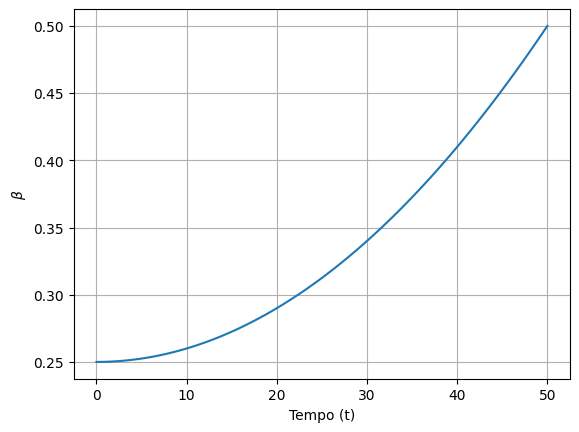

In [7]:

plt.plot(train_t, beta_t(train_t))
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.grid()
plt.savefig("../../images/real-beta-mono-beta.png")
plt.show()

In [8]:
# I_min, I_max = data_I.min(axis=0), data_I.max(axis=0)
# I_mean, I_std = data_I.mean(axis=0), data_I.std(axis=0)

# # Min/Max
# def scale(data):
#     return (data - I_min) / (I_max - I_min)

# def unscale(data):
#     return I_min + (I_max - I_min) * data

In [9]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I
    ]

# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial
def S0_val(_): return S0
def I0_val(_): return I0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_S = PointSetBC(data_t, sir_data[:,0:1], component=0)
data_I = PointSetBC(data_t, sir_data[:,1:2], component=1)

ics = [ic_S, ic_I]
data_conds = [
    data_I 
] 

conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=128,
    num_boundary=2,
    num_test=32,
    anchors=data_t
)

n_hidden_layers = 4
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]

activation = "tanh"
initializer = "Glorot normal"
optimizer = "adam"
lr = 0.002

eq_w = 10
ic_w = 10
data_w = 1

n_equations = 2

loss_weights = [eq_w] * n_equations + [ic_w] * len(ics) + [data_w] * len(data_conds)

# net = FNN(
#     topology, 
#     activation, 
#     initializer
# )

net = PFNN(
    topology, 
    activation, 
    initializer
)

model = Model(data, net)
# model = AdaptativeDataWeightModel(data, net, n_physics=n_equations + len(ics), n_data=1)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.008965 s



2025-12-12 19:30:25.146321: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1765578625.147063  576402 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2262 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
early_stopping = EarlyStopping(min_delta=1e-10, patience=10000)

losshistory, train_state = model.train(
    iterations=100000, 
    display_every=100,
    callbacks=[early_stopping]
)

# model.compile(
#     "L-BFGS", 
#     loss_weights=loss_weights
# )

# dde.optimizers.set_LBFGS_options(
#     # ftol=np.finfo(float).eps,
#     maxiter=25000,
#     ftol=1e-10,
#     gtol=1e-12
# )

# losshistory, train_state = model.train(
#     iterations=20000, 
#     display_every=100
# )

Training model...



2025-12-12 19:30:27.063783: I external/local_xla/xla/service/service.cc:163] XLA service 0x561bdfd9cb90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-12 19:30:27.063800: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-12-12 19:30:27.071207: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-12 19:30:27.130989: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1765578627.420318  576402 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [8.52e-02, 1.93e-02, 9.80e+00, 1.00e-03, 4.12e-02]    [4.61e-02, 2.00e-02, 9.80e+00, 1.00e-03, 4.12e-02]    []  
100       [1.32e-02, 5.22e-03, 4.06e-05, 8.19e-06, 5.23e-03]    [1.38e-02, 4.82e-03, 4.06e-05, 8.19e-06, 5.23e-03]    []  
200       [2.90e-03, 1.31e-03, 1.39e-06, 1.94e-08, 2.95e-03]    [2.73e-03, 1.30e-03, 1.39e-06, 1.94e-08, 2.95e-03]    []  
300       [1.42e-03, 1.12e-03, 1.04e-07, 1.80e-09, 2.62e-03]    [1.26e-03, 1.15e-03, 1.04e-07, 1.80e-09, 2.62e-03]    []  
400       [1.07e-03, 8.65e-04, 1.19e-08, 3.47e-08, 2.30e-03]    [9.33e-04, 8.93e-04, 1.19e-08, 3.47e-08, 2.30e-03]    []  
500       [8.28e-04, 6.52e-04, 1.61e-11, 3.68e-08, 2.02e-03]    [7.17e-04, 6.70e-04, 1.61e-11, 3.68e-08, 2.02e-03]    []  
600       [6.51e-04, 4.98e-04, 2.83e-09, 2.99e-08, 1.81e-03]    [5.61e-04, 5.10e-04, 2.83e-09, 2.99e-08, 1.81e-03]    []  
700      

In [11]:
model.save("../../models/mono-beta")

'../../models/mono-beta-28000.weights.h5'

In [12]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False,
    output_dir="../../losses", 
    loss_fname=f"loss-mono-beta",
    train_fname=f"train-mono-beta",
    test_fname=f"test-mono-beta")

Saving loss history to ../../losses/loss-mono-beta ...
Saving training data to ../../losses/train-mono-beta ...
Saving test data to ../../losses/test-mono-beta ...


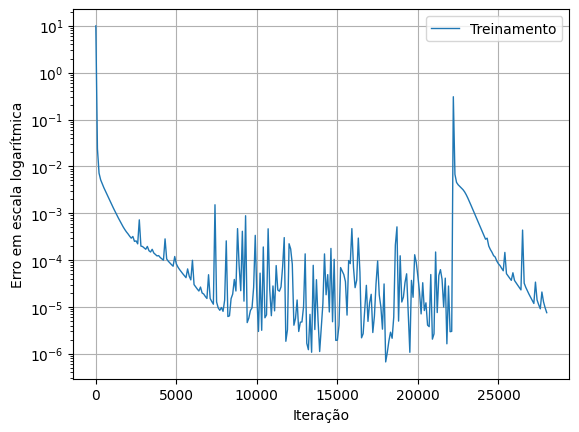

In [13]:
train = np.sum(losshistory.loss_train, axis=1)
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
# plt.semilogy(losshistory.steps, train, "o-", label="Treinamento", linewidth=2)
# plt.semilogy(losshistory.steps, test, "x-", label="Teste", linewidth=2)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../../images/loss-mono-beta.png")
plt.show()

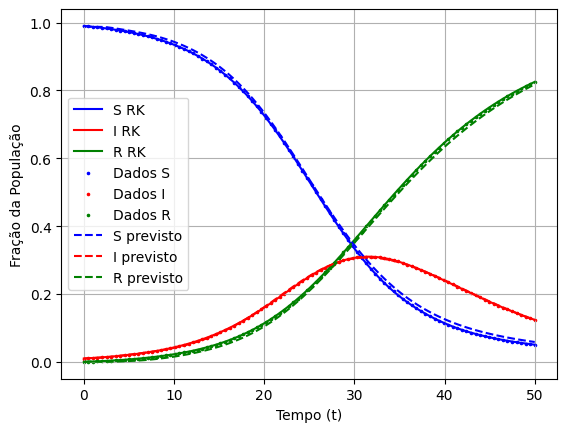

In [14]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

S_pred, I_pred = y_pred[:, 0], y_pred[:, 1]
R_pred = 1 - S_pred - I_pred  

sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = sir_test[:,2]

plt.plot(train_t, S_real, label="S RK", color="blue")
plt.plot(train_t, I_real, label="I RK", color="red")
plt.plot(train_t, R_real, label="R RK", color="green")

plt.scatter(train_t, sir_data[:,0], label="Dados S", color="blue", s=2.5)
plt.scatter(train_t, sir_data[:,1], label="Dados I", color="red", s=2.5)
plt.scatter(train_t, sir_data[:,2], label="Dados R", color="green", s=2.5)

plt.plot(test_t, S_pred, label="S previsto", linestyle="--", color="blue")
plt.plot(test_t, I_pred, label="I previsto", linestyle="--", color="red")
plt.plot(test_t, R_pred, label="R previsto", linestyle="--", color="green")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../../images/predicted-compartments-mono-beta.png")

plt.show()

[]

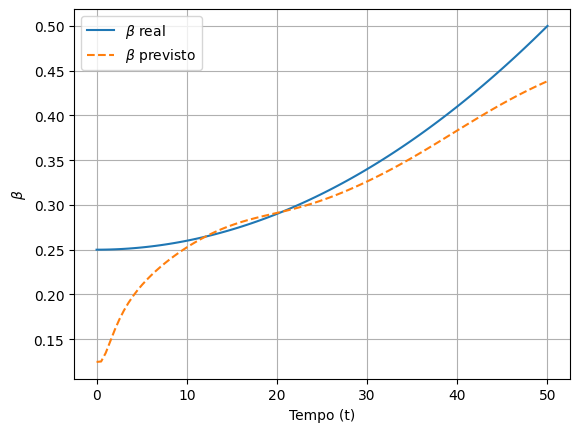

In [15]:
beta_pred = y_pred[:, 2]
beta_real = beta_t(test_t)
plt.plot(test_t, beta_real, label=r"$\beta$ real")
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../../images/predicted-beta-mono-beta.png")
plt.plot()

In [16]:
sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = 1 - S_real - I_real

### MSE

In [17]:
mean_squared_error(S_real, S_pred)

8.444482615045284e-05

In [18]:
mean_squared_error(I_real, I_pred)

1.7485020324943765e-06

In [19]:
mean_squared_error(R_real, R_pred)

8.067464079425966e-05

In [20]:
mean_squared_error(beta_real, beta_pred)

0.0013670939048342687

## L2

In [21]:
l2_relative_error(S_real, S_pred)

np.float64(0.0144684764328921)

In [22]:
l2_relative_error(I_real, I_pred)

np.float64(0.0068397313745459)

In [23]:
l2_relative_error(R_real, R_pred)

np.float64(0.021266292250606927)

In [24]:
l2_relative_error(beta_real, beta_pred)

np.float64(3.2063152559891357)

## L-Infinity

In [25]:
np.max(np.abs(S_real - S_pred))

np.float64(0.012884303859993035)

In [26]:
np.max(np.abs(I_real - I_pred))

np.float64(0.002697586457358958)

In [27]:
np.max(np.abs(R_real - R_pred))

np.float64(0.012794480970956368)

In [28]:
np.max(np.abs(beta_real - beta_pred))

np.float64(0.3753867214894052)

In [29]:
data_t

array([[ 0.        ],
       [ 0.50505051],
       [ 1.01010101],
       [ 1.51515152],
       [ 2.02020202],
       [ 2.52525253],
       [ 3.03030303],
       [ 3.53535354],
       [ 4.04040404],
       [ 4.54545455],
       [ 5.05050505],
       [ 5.55555556],
       [ 6.06060606],
       [ 6.56565657],
       [ 7.07070707],
       [ 7.57575758],
       [ 8.08080808],
       [ 8.58585859],
       [ 9.09090909],
       [ 9.5959596 ],
       [10.1010101 ],
       [10.60606061],
       [11.11111111],
       [11.61616162],
       [12.12121212],
       [12.62626263],
       [13.13131313],
       [13.63636364],
       [14.14141414],
       [14.64646465],
       [15.15151515],
       [15.65656566],
       [16.16161616],
       [16.66666667],
       [17.17171717],
       [17.67676768],
       [18.18181818],
       [18.68686869],
       [19.19191919],
       [19.6969697 ],
       [20.2020202 ],
       [20.70707071],
       [21.21212121],
       [21.71717172],
       [22.22222222],
       [22

In [30]:
sir_data[:,1]

array([0.01      , 0.01077257, 0.01160316, 0.01249615, 0.01345625,
       0.01448845, 0.01559816, 0.01679126, 0.01807406, 0.01945334,
       0.02093633, 0.02253071, 0.0242446 , 0.0260866 , 0.02806574,
       0.03018862, 0.0324643 , 0.03490692, 0.03753039, 0.0403483 ,
       0.04337397, 0.04662042, 0.0501004 , 0.05382636, 0.05781046,
       0.06206457, 0.06660029, 0.07142891, 0.07656144, 0.08200862,
       0.08778087, 0.09388777, 0.10032405, 0.10709422, 0.11420491,
       0.12165646, 0.12944302, 0.13755244, 0.14596638, 0.1546602 ,
       0.16360305, 0.17275782, 0.18208116, 0.19152348, 0.20102894,
       0.21053544, 0.21997465, 0.229272  , 0.23834666, 0.24711161,
       0.2554915 , 0.2634301 , 0.27087296, 0.27777121, 0.28408154,
       0.28976625, 0.29479317, 0.29913574, 0.30277297, 0.30568944,
       0.30787532, 0.30932633, 0.3100438 , 0.31003461, 0.30931122,
       0.3078917 , 0.30579964, 0.30306426, 0.29973972, 0.29590399,
       0.29161737, 0.28693626, 0.28191332, 0.2765974 , 0.27103

In [31]:
timeinterval.uniform_points(128)

array([[ 0.        ],
       [ 0.39370079],
       [ 0.78740157],
       [ 1.18110236],
       [ 1.57480315],
       [ 1.96850394],
       [ 2.36220472],
       [ 2.75590551],
       [ 3.1496063 ],
       [ 3.54330709],
       [ 3.93700787],
       [ 4.33070866],
       [ 4.72440945],
       [ 5.11811024],
       [ 5.51181102],
       [ 5.90551181],
       [ 6.2992126 ],
       [ 6.69291339],
       [ 7.08661417],
       [ 7.48031496],
       [ 7.87401575],
       [ 8.26771654],
       [ 8.66141732],
       [ 9.05511811],
       [ 9.4488189 ],
       [ 9.84251969],
       [10.23622047],
       [10.62992126],
       [11.02362205],
       [11.41732283],
       [11.81102362],
       [12.20472441],
       [12.5984252 ],
       [12.99212598],
       [13.38582677],
       [13.77952756],
       [14.17322835],
       [14.56692913],
       [14.96062992],
       [15.35433071],
       [15.7480315 ],
       [16.14173228],
       [16.53543307],
       [16.92913386],
       [17.32283465],
       [17

In [36]:
sir_data[:,0:1].reshape(-1, 1)

array([[0.99      ],
       [0.9887031 ],
       [0.98730773],
       [0.98580641],
       [0.98419111],
       [0.98245346],
       [0.98058435],
       [0.97857383],
       [0.97641117],
       [0.97408481],
       [0.97158243],
       [0.96889084],
       [0.9659961 ],
       [0.96288343],
       [0.95953726],
       [0.95594418],
       [0.95208764],
       [0.94794509],
       [0.94349366],
       [0.93871016],
       [0.93357106],
       [0.92805253],
       [0.92213042],
       [0.91578027],
       [0.90897728],
       [0.90169635],
       [0.89391206],
       [0.88559867],
       [0.8767301 ],
       [0.86728   ],
       [0.85722165],
       [0.84652913],
       [0.83520164],
       [0.82321538],
       [0.81053922],
       [0.79715048],
       [0.78303489],
       [0.76818666],
       [0.75260839],
       [0.73631116],
       [0.71931445],
       [0.70164621],
       [0.68334281],
       [0.66444905],
       [0.64501819],
       [0.62511191],
       [0.60480033],
       [0.584